In [1]:
import sys

sys.path.append("..")

import torch
from torch.utils.data import DataLoader
import numpy as np
from common import RawImageProcessor, ModelImageProcessor
from dataset import Dataset
from model import get_model
from loss import Loss
from train_utils import compute_accuracy
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm

In [2]:
PATH_TO_MODELS = "saved_models"

# Hyperparameters

In [3]:
BATCH_SIZE = 32
IMG_SHAPE = 250
NUM_EPOCHS = 50
LEARNING_RATE = 5e-4

# Loading the Dataset

* The images and labels must be in sepparate directories with the same filename (without the extension)
* Images in `.jpg`, labels in `.json`
* The Dataset uses a `RawImageProcessor` object that processes the raw image. The following transformations are applied:
    * convert to grayscale 
    * reshape to a square size
* Labels are also reshaped according to the image reshape factor
* The dataset returns images and labels as `torch.Tensor`. Further processing is done to the image, which is performed by the `ModelImageProcessor` object. The following transformations are applied:
    * convert `np.ndarray` to `torch.Tensor`
    * reshape the grayscale image to `(3,IMG_SHAPE,IMG_SHAPE)`
    * normalize pixel intensities to $[0,1]$ range
* Labels are also normalized to $[0,1]$ range with respect to the square image shape

In [4]:
dataset = Dataset.from_folder(
    img_dir = r"..\data\images",
    labels_dir = r"..\data\labels",
    raw_processor = RawImageProcessor(IMG_SHAPE, IMG_SHAPE, True),
    model_processor = ModelImageProcessor()
)

In [5]:
print(len(dataset))

80


Splitting in train/val/test

In [6]:
train_split = 0.5
val_split = 0.25

num_samples = len(dataset)
idx = np.arange(num_samples)
np.random.seed(42)
np.random.shuffle(idx)

train_idx = idx[0:int(train_split*num_samples)]
val_idx = idx[int(train_split*num_samples):int((train_split+val_split)*num_samples)]
test_idx = idx[int((train_split+val_split)*num_samples):]

train_dataset = dataset.select(train_idx)
val_dataset = dataset.select(val_idx)
test_dataset = dataset.select(test_idx)

In [7]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

40
20
20


Increasing the dataset with augmentations.

In [8]:
aug = A.Compose(
    [
        A.RandomResizedCrop(IMG_SHAPE, IMG_SHAPE, scale=(0.75, 0.9)),
        A.HorizontalFlip(),
        A.RandomBrightnessContrast(p=0.2),
    ],
    keypoint_params=A.KeypointParams(format='xy')
)
train_dataset.augment(5, aug)

In [9]:
print(len(train_dataset))
print(len(val_dataset))

240
20


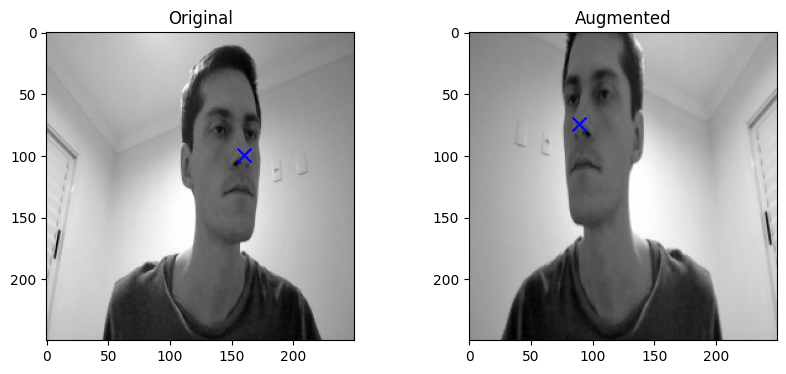

In [10]:
og_img = train_dataset.images[0]
og_y = train_dataset.y[0]

new = aug(image=og_img, keypoints=[og_y])
new_img = new["image"]
new_y = new["keypoints"][0]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(og_img, cmap="gray")
plt.scatter(og_y[0], og_y[1], marker="x", color="blue" ,s=100)

plt.subplot(1,2,2)
plt.title("Augmented")
plt.imshow(new_img, cmap="gray")
plt.scatter(new_y[0], new_y[1], marker="x", color="blue" ,s=100)

Creating dataloaders

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Training

Instantiating the model (MobileNet) with an output dimension of 2 (coordinates x,y)

In [12]:
model = get_model(num_output_features=2)

model = model.cuda()
optim = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
loss = Loss()

train_losses = []
val_losses = []

num_train_samples = len(train_dataset)
num_val_samples = len(val_dataset)

# training loop
for epoch in tqdm(range(NUM_EPOCHS)):
    running_loss = 0
    for x, y in train_dataloader:
        optim.zero_grad()
        x_pred = model(x.to("cuda"))
        l = loss(x_pred.to("cuda"), y.to("cuda")).sum()
        l.backward()
        optim.step()
        running_loss += l.to("cpu").detach()
    train_losses.append(running_loss / num_train_samples)

    running_loss = 0
    for  x, y in val_dataloader:
        with torch.no_grad():
            x_pred = model(x.to("cuda"))
            l = loss(x_pred.to("cuda"), y.to("cuda")).sum()
            running_loss += l.to("cpu").detach()
    val_losses.append(running_loss / num_val_samples)

Using cache found in C:\Users\eduar/.cache\torch\hub\pytorch_vision_main
C:\Users\eduar/.cache\torch\hub\pytorch_vision_main\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
100%|██████████| 50/50 [01:38<00:00,  1.96s/it]


Text(0.5, 0, 'Epoch')

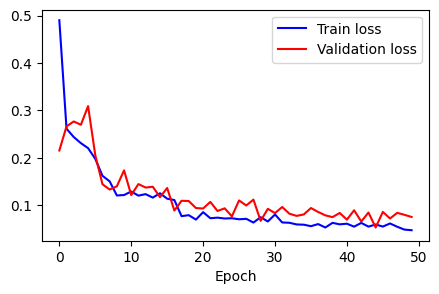

In [13]:
plt.figure(figsize=(5,3))
plt.plot(train_losses, color="blue")
plt.plot(val_losses, color="red")
plt.legend(["Train loss", "Validation loss"])
plt.xlabel("Epoch")

Evaluating in terms of accuracy

In [14]:
train_acc = compute_accuracy(model, train_dataloader)
val_acc = compute_accuracy(model, val_dataloader)
test_acc = compute_accuracy(model, test_dataloader)

print(f"Training accuracy: {round(train_acc,2)}")
print(f"Validation accuracy: {round(val_acc,2)}")
print(f"Test accuracy: {round(test_acc,2)}")

Training accuracy: 0.9
Validation accuracy: 0.8
Test accuracy: 0.75


Saving model

In [15]:
model.eval();
model.cpu();
torch.save(model, f"{PATH_TO_MODELS}\model.pkl")